In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

dataset = scipy.io.loadmat('dataset3.mat')
theta_vk_i = dataset['theta_vk_i']  # a 3xK matrix where kth column is the 
                                    # axis-angle representation of the groundtruth value of C_{v_k,i}. 
                                    # Use this vector as psi_k in (3.3c) to recover the rotation matrix.
r_i_vk_i = dataset['r_i_vk_i']  # a 3xK matrix where the kth column is the groundtruth value of r_i^{v_k,i} [m]
t = dataset['t']  # a 1xK matrix of time values t(k) [s]
w_vk_vk_i = dataset['w_vk_vk_i']  # a 3xK matrix where kth column is the measured rotational velocity,
                                  # w_{v_k}^{v_k,i} [rad/s]
w_var = dataset['w_var']  # a 3x1 matrix of the computed variances (based on groundtruth) of the
                          # rotational speeds [rad^2/s^2]
v_vk_vk_i = dataset['v_vk_vk_i']  # a 3xK matrix where the kth column is the measured translational velocity, 
                                  # v_{v_k}^{v_k,i} [m/s]
v_var = dataset['v_var']  # a 3x1 matrix of the computed variances (based on groundtruth) of the 
                          # translational speeds [m^2/s^2]
rho_i_pj_i = dataset['rho_i_pj_i']  # a 3x20 matrix where jth column is the position of feature j, 
                                    # rho_i^{p_j,i} [m]
y_k_j = dataset['y_k_j']  # a 4xKx20 array of observations, y_k^j [pixels]. 
                          # All components of y_k_j[:,k,j] will be -1 if the observation is invalid.
y_var = dataset['y_var']  # a 4x1 matrix of the computed variances (based on groundtruth) of the 
                          # stereo measurements [pixels^2]
C_c_v = dataset['C_c_v']  # a 3x3 matrix giving the rotation from the vehicle frame to the camera frame, C_{c,v}
rho_v_c_v = dataset['rho_v_c_v']  # a 3x1 matrix giving the translation from the vehicle frame to the 
                                  # camera frame, rho_v^{c,v} [m]
fu = dataset['fu'].item()  # the stereo camera's horizontal focal length, f_u [pixels]
fv = dataset['fv'].item()  # the stereo camera's vertical focal length, f_v [pixels]
cu = dataset['cu'].item()  # the stereo camera's horizontal optical center, c_u [pixels]
cv = dataset['cv'].item()  # the stereo camrea's vertical optical center, c_v [pixels]
b = dataset['b'].item()  # the stereo camera baseline, b [m]

Text(0, 0.5, 'number of landmarks observed')

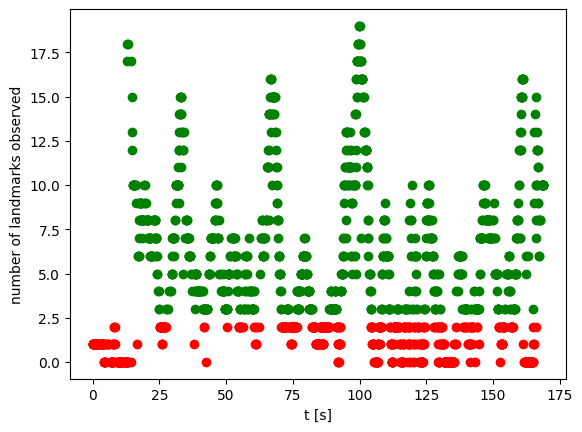

In [2]:
# Q4

r_count = 0
lcount = np.zeros(np.shape(t)[1])
for k in range(np.shape(t)[1]):
    for j in range(19):
        if y_k_j[1,k,j] == -1:
            continue
        else:
            r_count += 1
    lcount[k] = r_count
    r_count = 0
for i in range(np.shape(t)[1]):
    if lcount[i] >= 3:
        plt.scatter(t[0,i], lcount[i], color = 'green')
    else:
        plt.scatter(t[0,i], lcount[i], color = 'red')
plt.xlabel('t [s]')
plt.ylabel('number of landmarks observed')


Text(0, 0.5, 'number of landmarks observed')

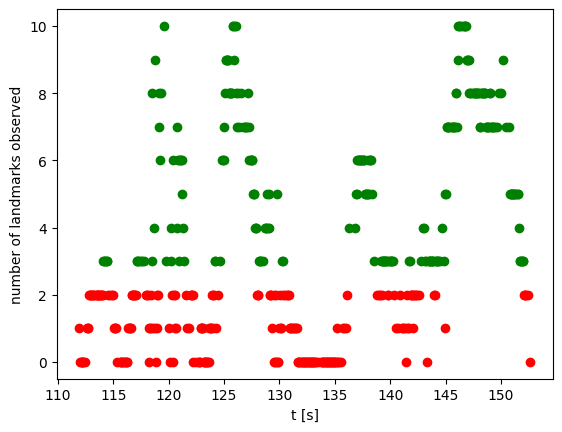

In [3]:
# Q4 from 1215 to 1714 
r_count = 0
lcount = np.zeros(500)
k1 = 1215
k2 = 1714
for k in range(k1, k2):
    for j in range(19):
        if y_k_j[1,k,j] == -1:
            continue
        else:
            r_count += 1
    lcount[k - 1215] = r_count
    r_count = 0
for i in range(k1, k2):
    if lcount[i - 1215] >= 3:
        plt.scatter(t[0,i], lcount[i-1215], color = 'green')
    else:
        plt.scatter(t[0,i], lcount[i-1215], color = 'red')
plt.xlabel('t [s]')
plt.ylabel('number of landmarks observed')

In [4]:
# Q5

In [5]:
# Functions

# Wrap to pi function
def omfil(ang):
    return (ang + np.pi) % (2*np.pi) - np.pi 

# Convert theta_vk_i to the groundtruth of C_vk_i
def Psi_func(theta):
    theta = theta.reshape(3,1)
    mag = np.linalg.norm(theta)
    # Skew-symmetric operation
    theta_u = (theta/mag).reshape(3,1)
    theta_skews = np.array([[0, -theta_u[2][0], theta_u[1][0]],
                            [theta_u[2][0], 0, -theta_u[0][0]],
                            [-theta_u[1][0], theta_u[0][0], 0]])
    return (np.cos(mag) * np.eye(3)) + ((1 - np.cos(mag)) * (theta/mag) @ (theta/mag).T) - (np.sin(mag) * theta_skews)

# Combine translation and rotation to poses
def T_pose(C, r):
    r = r.reshape(3, 1)
    return np.vstack((np.hstack((C, r)), np.array([0, 0, 0, 1])))

# Transformation matrix for camera
A = T_pose(C_c_v, -C_c_v @ rho_v_c_v)

# \wedge operation that lift a vector to lie group
def se3(s):
    if s.shape == (3, 1):
        s_wed = np.zeros((3, 3))
        s_wed[0, 1] = -s[2]
        s_wed[0, 2] = s[1]
        s_wed[1, 0] = s[2]
        s_wed[1, 2] = -s[0]
        s_wed[2, 0] = -s[1]
        s_wed[2, 1] = s[0]
    elif s.shape == (6, 1):
        s_wed = np.zeros((4, 4))
        s_wed[0, 1] = -s[5]
        s_wed[0, 2] = s[4]
        s_wed[1, 0] = s[5]
        s_wed[1, 2] = -s[3]
        s_wed[2, 0] = -s[4]
        s_wed[2, 1] = s[3]
        s_wed[0, 3] = s[0]
        s_wed[1, 3] = s[1]
        s_wed[2, 3] = s[2]
    return s_wed

# \vee operation or inverse \wedge to get the vector form a skew-symmetric form
def se3_inv(S):
    if S.shape == (3, 3):
        s_vee = np.zeros((3, 1))
        s_vee[0] = S[2, 1]
        s_vee[1] = S[0, 2]
        s_vee[2] = S[1, 0]
    elif S.shape == (4, 4):
        s_vee = np.zeros((6, 1))
        s_vee[0] = S[0, 3]
        s_vee[1] = S[1, 3]
        s_vee[2] = S[2, 3]
        s_vee[3] = S[2, 1]
        s_vee[4] = S[0, 2]
        s_vee[5] = S[1, 0]
    return s_vee

# Extract C from the last T
def extC(T):
    return T[0:3, 0:3]

# Extract r from the last T
def extr(T):
    return T[0:3, 3]

# Initial guess
def initial_guess(k1, k2, T_ig=None):
    Tn = np.zeros((t.shape[1], 4, 4))
    if T_ig is None:
        C_0 = Psi_func(theta_vk_i[:,k1])
        r_0 = -C_0 @ r_i_vk_i[:,k1]
        T_ig = T_pose(C_0, r_0) 
    Tn[k1] = T_ig
    for i in range(k1+1, k2+1):
        Tk = t[0][i] - t[0][i-1]
        C_kp = extC(Tn[i-1])
        theta_f = omfil(w_vk_vk_i[:, i-1] * Tk)
        Psi = Psi_func(theta_f)
        C_k = Psi @ C_kp
        r_kp = -C_kp.T @ extr(Tn[i-1])
        dr = C_kp.T @ (v_vk_vk_i[:, i-1] * Tk)
        r_k = -C_k @ (r_kp + dr)
        Tn[i] = T_pose(C_k, r_k)
    return Tn

# Camera matrix
M = np.array([[fu, 0, cu, 0], [0, fv, cv, 0], [fu, 0, cu, -fu*b], [0, fv, cv, 0]])

# GN algorithm
def GN(T_op, k1=1215, k2=1714): # Change this to the timestep from each question
    dk = k2 - k1

    Fn = []
    Gn = []
    e_v_kn = []
    Qn = []
    Rn = []
    e_y_kn = []
        
    # Calculate e_v0
    C_0 = Psi_func(theta_vk_i[:, k1])
    r_0 = -C_0 @ r_i_vk_i[:, k1]
    T_0 = T_pose(C_0, r_0)
    e_v_kn.append(se3_inv(scipy.linalg.logm(T_0 @ np.linalg.inv(T_op[k1]))))

    # Calculate e_v_k
    for i in range(k1+1, k2+1):
        Tk = t[0][i] - t[0][i-1]
        T_opk = T_op[i]
        T_opk_p = T_op[i-1]
        varpi_k = np.hstack((-v_vk_vk_i[:, i], -w_vk_vk_i[:, i])).reshape((6,1)) # Could be negative of this depends on the reference frame
        Xi_k = scipy.linalg.expm(Tk * se3(varpi_k))
        e_v_k = se3_inv(scipy.linalg.logm(Xi_k @ T_opk_p @ np.linalg.inv(T_opk)))
        e_v_kn.append(e_v_k)
        # Assume E term to be 1
        F_kpad = T_opk @ np.linalg.inv(T_opk_p)
        # Adjoint of F_kpad
        F_kp = np.zeros((6, 6))
        C = extC(F_kpad)
        r = extr(F_kpad)
        F_kp[0:3, 0:3] = C
        F_kp[3:, 3:] = C
        F_kp[:3, 3:] = se3(r.reshape((3, 1))) @ C
        Fn.append(F_kp)

    # Calculate e_y_k
    for k in range(k1, k2+1):
        Tk = t[0][k] - t[0][k-1]
        T_opk = T_op[k]
        G_kn = []
        e_yn = []

        for j in range(20):
            y_j = y_k_j[:, k, j].reshape((4,1))
            if y_j[0] == -1: continue
            p_j = np.vstack((rho_i_pj_i[:, j].reshape((3,1)), np.eye(1)))
            p_j_c = A @ T_opk @ p_j
            
            # Calculate S_k_j Jacobian
            S_k_j_i = p_j_c
            ds = np.array([[1, 0, -S_k_j_i[0].item()/S_k_j_i[2].item(), 0],
                           [0, 1, -S_k_j_i[1].item()/S_k_j_i[2].item(), 0],
                           [0, 0, 0, 0],
                           [0, 0, -S_k_j_i[3].item()/S_k_j_i[2].item(), 1]])
            S_k_j = M @ ((1/S_k_j_i[2].item())*ds)

            # Circ operation to get Z_k_j matrix
            Z_k_j_circ = T_opk @ p_j
            rho = Z_k_j_circ[:-1]
            eta = Z_k_j_circ[3, 0]
            Z = np.zeros((4, 6))
            Z[:3, :3] = eta * np.eye(3)
            Z[:3, 3:] = -se3(rho)
            Z_k_j = A @ Z
            
            G_kn.append(S_k_j @ Z_k_j)
            e_yn.append(y_j - M @ (p_j_c/p_j_c[2].item()))
        # In case there's no observation
        if G_kn:
            G_k = np.vstack(G_kn)
            e_y_k = np.vstack(e_yn)
            Gn.append(G_k)
            e_y_kn.append(e_y_k)
        else:
            Gn.append(np.zeros((0,6)))
        # Motion covariance matrix
        Qn.append(Tk**2 * np.diag(np.vstack((v_var, w_var)).squeeze()))
        # Observation covariance matrix
        for z in range(len(G_kn)):
            Rn.append(np.diag(y_var.squeeze()))
    # Calculate H matrix which is assambled by F and G
    H_t = np.eye(dk*6 + 6)
    for i in range(len(Fn)):
        H_t[6*i+6:6*i+12, 6*i:6*i+6] = -Fn[i]
    H_b = scipy.linalg.block_diag(*Gn)
    H = np.vstack((H_t, H_b))

    e_t = np.vstack(e_v_kn)
    # Still in case for no observation
    if len(e_y_kn) == 0:
        e_bar = e_t
    else:
        e_b = np.vstack(e_y_kn)
        e_bar = np.vstack((e_t, e_b))
    # The whole covariance matrix
    W = scipy.linalg.block_diag(*(Qn + Rn))
    W_in = W.copy()
    np.fill_diagonal(W_in, 1/W.diagonal())
    HTWin = H.T @ W_in
    # B here is A matrix in the assignment answer since A is used earlier
    B = HTWin @ H
    b = HTWin @ e_bar
    # Optimal delta x after minimize the cost function derivative
    x_star = np.linalg.inv(B) @ b

    for i in range(dk+1):
        T_op[i+k1] = scipy.linalg.expm(se3(x_star[6*i:6*i+6])) @ T_op[i+k1]

    return T_op, B

In [6]:
# Q5(a)

In [7]:
# Get groundtruth pose
T_true = np.zeros((t.shape[1], 4, 4))
for i in range(1215, 1714+1): # Change this to the timestep from each question
    C_true = Psi_func(theta_vk_i[:, i])
    r_true = -C_true @ r_i_vk_i[:, i]
    T_n = T_pose(C_true, r_true)
    T_true[i] = T_n

# Get initial pose
T_initial = initial_guess(1215, 1714, T_ig=None) # Change this to the timestep from each question
T_op, B = GN(T_initial, 1215, 1714) # Change this to the timestep from each question
e_th = []
e_r = []

for k in range(1215, 1714+1): # Change this to the timestep from each question
    C_true = extC(T_true[k])
    C_op = extC(T_op[k])
    r_true = extr(T_true[k])
    r_op = extr(T_op[k])

    e_th.append(se3_inv(np.eye(3) - C_op @ C_true.T))
    e_r.append(r_op - r_true)

e_th = np.array(e_th)
e_r = np.array(e_r)

# Extract covariance matrix
var = np.linalg.inv(B).diagonal()
var_rx = var[0::6]
var_ry = var[1::6]
var_rz = var[2::6]
var_thx = var[3::6]
var_thy = var[4::6]
var_thz = var[5::6]

time = np.arange(1215, 1714+1)

C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[0, 1] = -s[5]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[0, 2] = s[4]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[1, 0] = s[5]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:41: Depre

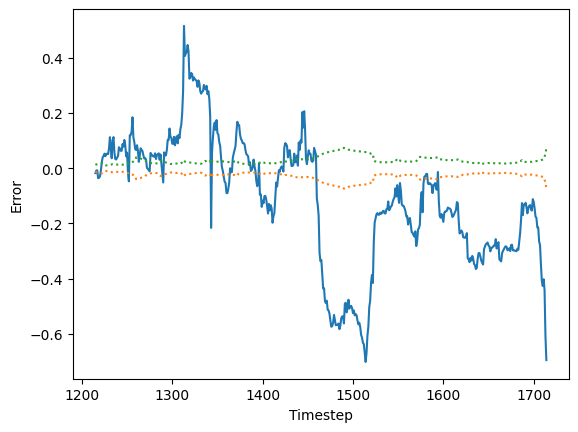

In [9]:
# e_r_x plot
plt.plot(time, e_r[:,0])
plt.plot(time, -3 * np.sqrt(var_rx), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_rx), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

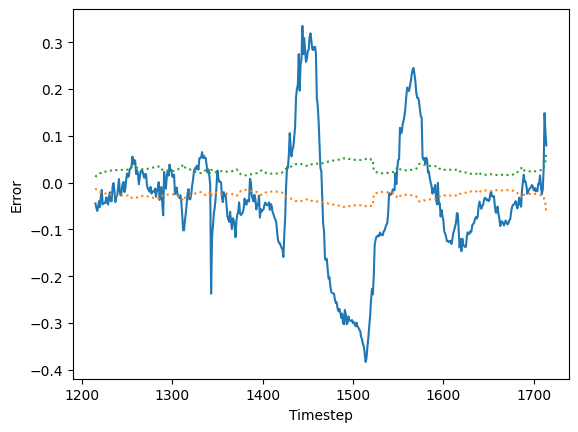

In [10]:
# e_r_y plot
plt.plot(time, e_r[:,1])
plt.plot(time, -3 * np.sqrt(var_ry), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_ry), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

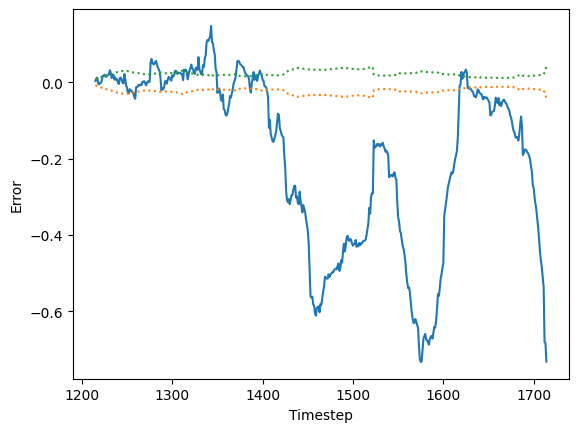

In [11]:
# e_r_z plot
plt.plot(time, e_r[:,2])
plt.plot(time, -3 * np.sqrt(var_rz), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_rz), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

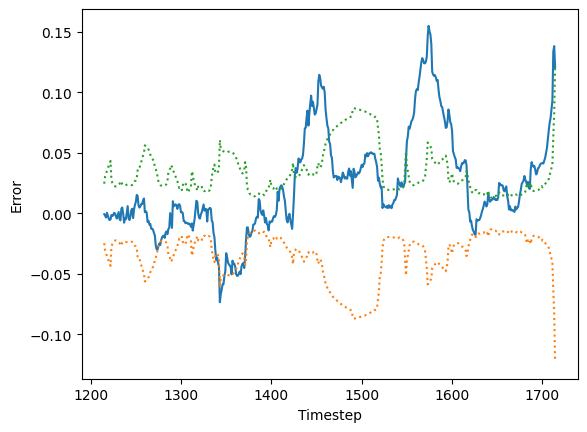

In [12]:
# e_th_x plot
plt.plot(time, e_th[:,0])
plt.plot(time, -3 * np.sqrt(var_thx), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thx), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

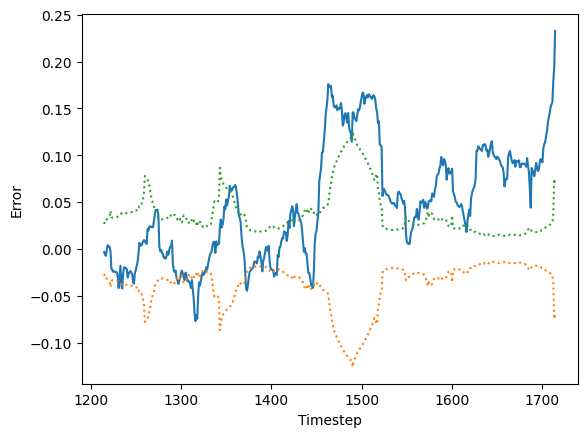

In [13]:
# e_th_y plot
plt.plot(time, e_th[:,1])
plt.plot(time, -3 * np.sqrt(var_thy), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thy), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

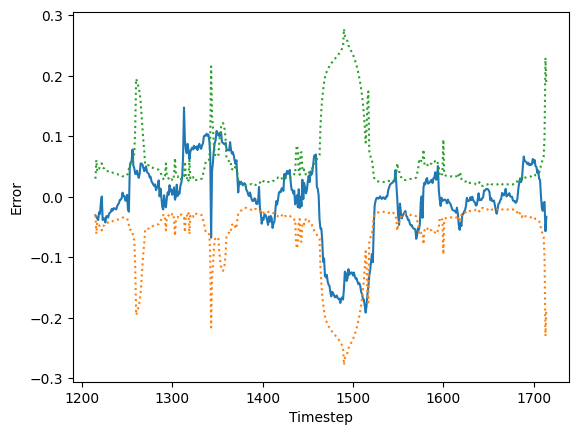

In [14]:
# e_th_z plot
plt.plot(time, e_th[:,2])
plt.plot(time, -3 * np.sqrt(var_thz), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thz), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

In [15]:
# Q5(b)

In [15]:
# Get groundtruth pose
T_true = np.zeros((t.shape[1], 4, 4))
for i in range(1215, 1714+1): # Change this to the timestep from each question
    C_true = Psi_func(theta_vk_i[:, i])
    r_true = -C_true @ r_i_vk_i[:, i]
    T_n = T_pose(C_true, r_true)
    T_true[i] = T_n

e_th = []
e_r = []

kappa = 50
k1 = 1215
k2 = 1714
T_initial = initial_guess(1215, 1215+kappa) # Change this to the timestep from each question
T_op, B = GN(T_initial, 1215, 1215+kappa) # Change this to the timestep from each question
Tn = np.zeros_like(T_op)
Bn = np.zeros(((1714-1215+1)*6, (1714-1215+1)*6)) # Change this to the timestep from each question
Tn[1215] = T_op[1215] # Change this to the timestep from each question
var = np.linalg.inv(B).diagonal()
Bn[0:6, 0:6] = np.linalg.inv(np.diag(var[0:6]))

for i in range(1215+1, 1714+1): # Change this to the timestep from each question
    T_initial = initial_guess(i, i+kappa, T_ig=Tn[i-1])
    T_op, B = GN(T_initial, i, i+kappa)
    Tn[i] = T_op[i]
    var = np.linalg.inv(B).diagonal()
    Bn[(i-1215)*6:(i-1215)*6+6, (i-1215)*6:(i-1215)*6+6] = np.linalg.inv(np.diag(var[0:6])) # Change this to the timestep from each question

for k in range(1215, 1714+1): # Change this to the timestep from each question
    C_true = extC(T_true[k])
    C_op = extC(Tn[k])
    r_true = extr(T_true[k])
    r_op = extr(Tn[k])

    e_th.append(se3_inv(np.eye(3) - C_op @ C_true.T))
    e_r.append(r_op - r_true)

e_th = np.array(e_th)
e_r = np.array(e_r)

# Extract covariance matrix
var = np.linalg.inv(Bn).diagonal()
var_rx = var[0::6]
var_ry = var[1::6]
var_rz = var[2::6]
var_thx = var[3::6]
var_thy = var[4::6]
var_thz = var[5::6]

time = np.arange(1215, 1714+1)

C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[0, 1] = -s[5]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[0, 2] = s[4]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[1, 0] = s[5]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:41: Depre

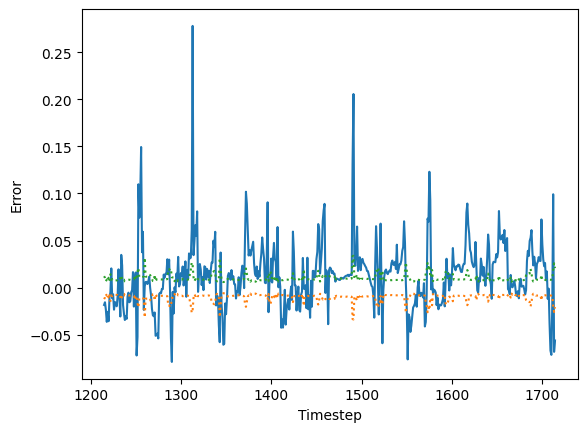

In [16]:
# e_r_x plot
plt.plot(time, e_r[:,0])
plt.plot(time, -3 * np.sqrt(var_rx), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_rx), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

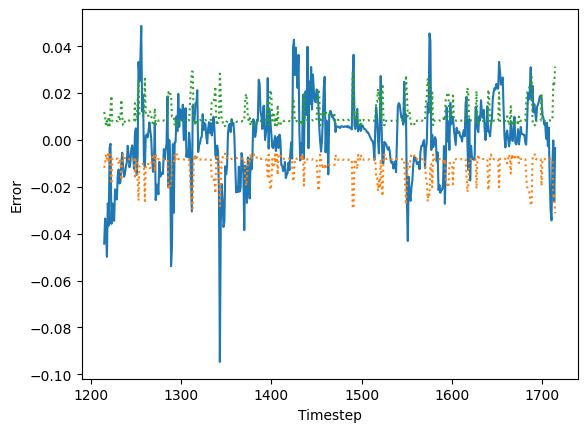

In [17]:
# e_r_y plot
plt.plot(time, e_r[:,1])
plt.plot(time, -3 * np.sqrt(var_ry), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_ry), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

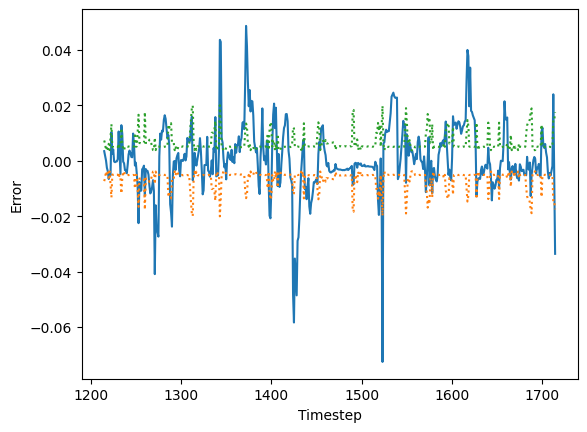

In [18]:
# e_r_z plot
plt.plot(time, e_r[:,2])
plt.plot(time, -3 * np.sqrt(var_rz), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_rz), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

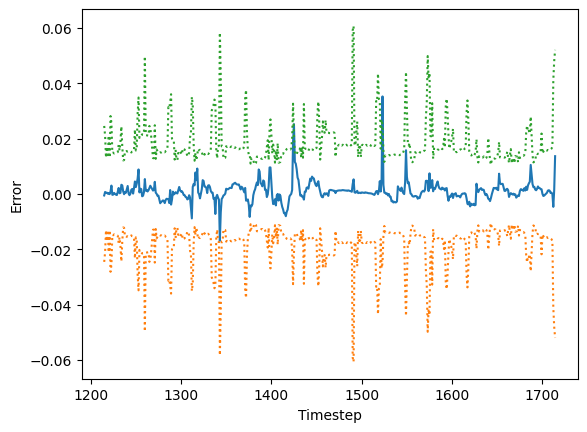

In [19]:
# e_th_x plot
plt.plot(time, e_th[:,0])
plt.plot(time, -3 * np.sqrt(var_thx), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thx), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

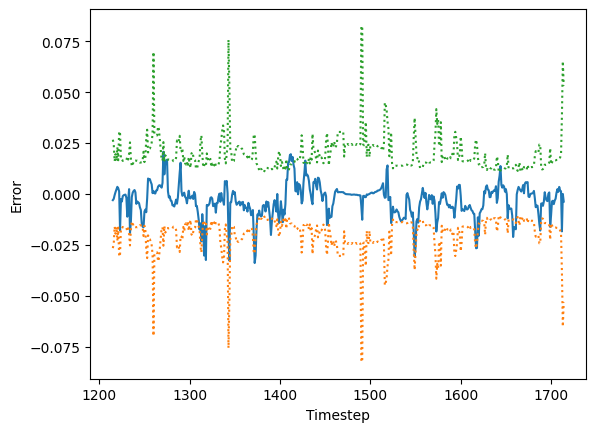

In [20]:
# e_th_y plot
plt.plot(time, e_th[:,1])
plt.plot(time, -3 * np.sqrt(var_thy), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thy), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

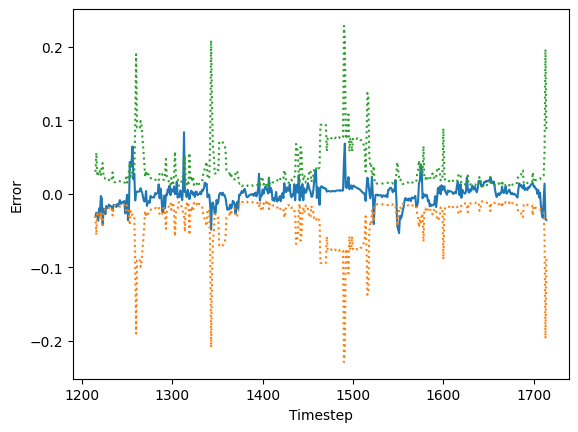

In [21]:
# e_th_z plot
plt.plot(time, e_th[:,2])
plt.plot(time, -3 * np.sqrt(var_thz), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thz), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

In [33]:
# Q5(c)

In [24]:
# Get groundtruth pose
T_true = np.zeros((t.shape[1], 4, 4))
for i in range(1215, 1714+1): # Change this to the timestep from each question
    C_true = Psi_func(theta_vk_i[:, i])
    r_true = -C_true @ r_i_vk_i[:, i]
    T_n = T_pose(C_true, r_true)
    T_true[i] = T_n

e_th = []
e_r = []

kappa = 10
k1 = 1215
k2 = 1714
T_initial = initial_guess(1215, 1215+kappa) # Change this to the timestep from each question
T_op, B = GN(T_initial, 1215, 1215+kappa) # Change this to the timestep from each question
Tn = np.zeros_like(T_op)
Bn = np.zeros(((1714-1215+1)*6, (1714-1215+1)*6)) # Change this to the timestep from each question
Tn[1215] = T_op[1215] # Change this to the timestep from each question
var = np.linalg.inv(B).diagonal()
Bn[0:6, 0:6] = np.linalg.inv(np.diag(var[0:6]))

for i in range(1215+1, 1714+1): # Change this to the timestep from each question
    T_initial = initial_guess(i, i+kappa, T_ig=Tn[i-1])
    T_op, B = GN(T_initial, i, i+kappa)
    Tn[i] = T_op[i]
    var = np.linalg.inv(B).diagonal()
    Bn[(i-1215)*6:(i-1215)*6+6, (i-1215)*6:(i-1215)*6+6] = np.linalg.inv(np.diag(var[0:6])) # Change this to the timestep from each question

for k in range(1215, 1714+1): # Change this to the timestep from each question
    C_true = extC(T_true[k])
    C_op = extC(Tn[k])
    r_true = extr(T_true[k])
    r_op = extr(Tn[k])

    e_th.append(se3_inv(np.eye(3) - C_op @ C_true.T))
    e_r.append(r_op - r_true)

e_th = np.array(e_th)
e_r = np.array(e_r)

# Extract covariance matrix
var = np.linalg.inv(Bn).diagonal()
var_rx = var[0::6]
var_ry = var[1::6]
var_rz = var[2::6]
var_thx = var[3::6]
var_thy = var[4::6]
var_thz = var[5::6]

time = np.arange(1215, 1714+1)

C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[0, 1] = -s[5]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[0, 2] = s[4]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_wed[1, 0] = s[5]
C:\Users\maxxi\AppData\Local\Temp\ipykernel_5572\2043185697.py:41: Depre

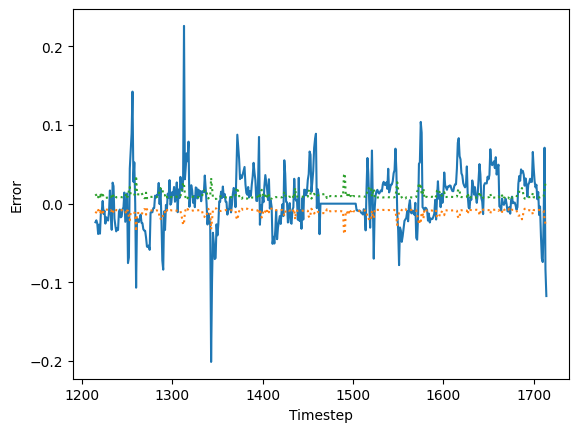

In [25]:
# e_r_x plot
plt.plot(time, e_r[:,0])
plt.plot(time, -3 * np.sqrt(var_rx), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_rx), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

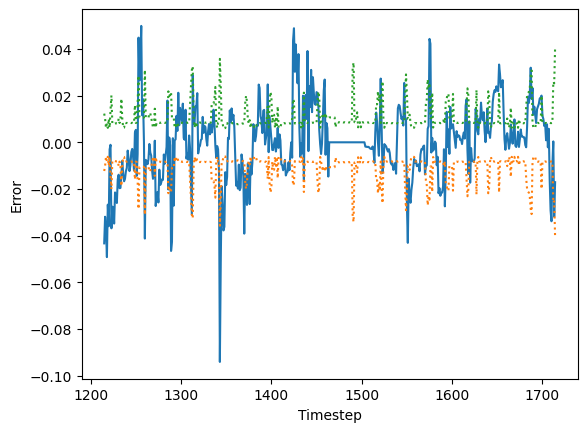

In [26]:
# e_r_y plot
plt.plot(time, e_r[:,1])
plt.plot(time, -3 * np.sqrt(var_ry), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_ry), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

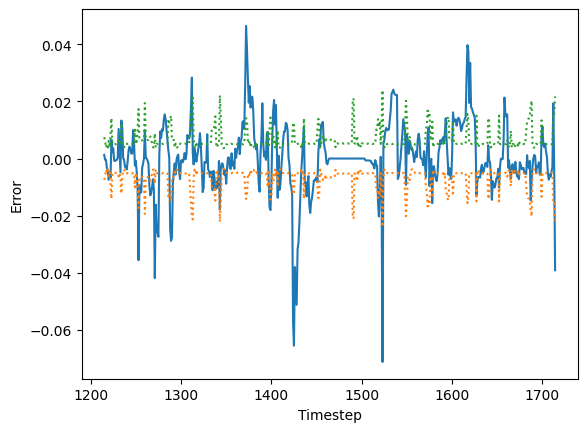

In [27]:
# e_r_z plot
plt.plot(time, e_r[:,2])
plt.plot(time, -3 * np.sqrt(var_rz), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_rz), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

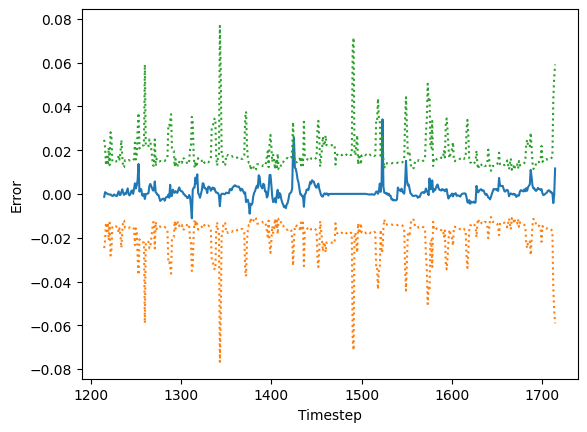

In [28]:
# e_th_x plot
plt.plot(time, e_th[:,0])
plt.plot(time, -3 * np.sqrt(var_thx), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thx), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

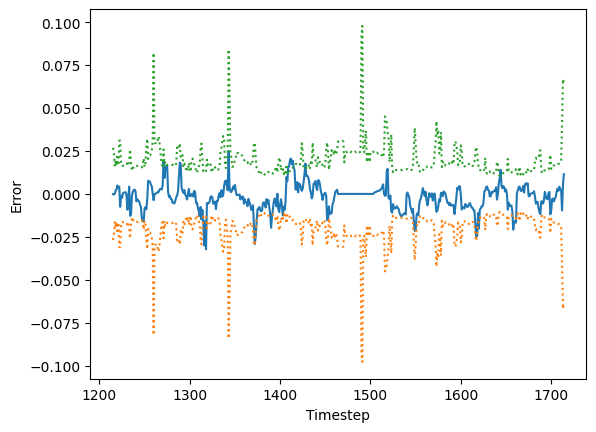

In [29]:
# e_th_y plot
plt.plot(time, e_th[:,1])
plt.plot(time, -3 * np.sqrt(var_thy), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thy), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()

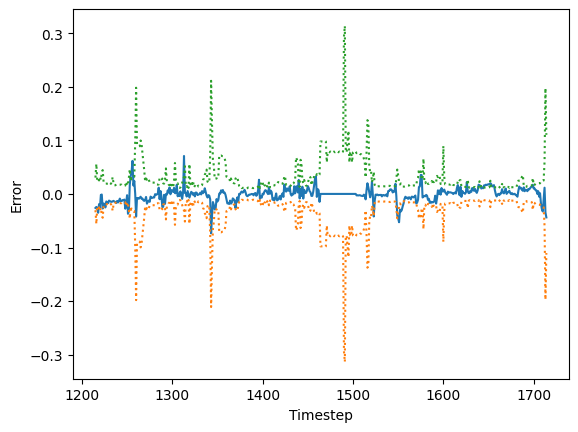

In [30]:
# e_th_z plot
plt.plot(time, e_th[:,2])
plt.plot(time, -3 * np.sqrt(var_thz), linestyle=':')
plt.plot(time, 3 * np.sqrt(var_thz), linestyle=':')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.show()